In [463]:
import networkx as nx 
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd 
import os
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.model_selection import train_test_split

### Getting plays from the folder.

In [3]:
def get_gexf_dict(folder):
    """ достаём словарь сетей в формате gexf """
    plays_paths = []
    for i in os.walk("./gexf"):
        for play in i[2]:
            plays_paths.append("./gexf/"+play)
            
    play_graph_dict = {}
    for path in plays_paths:
        play_name = path.split("/")[-1].replace(".gexf", "")
        play_graph_dict[play_name] = nx.Graph(nx.read_gexf(path)) 

    return play_graph_dict

In [4]:
play_graph_dict = get_gexf_dict("./gexf")

In [5]:
play_graph_dict["sumarokov-gamlet"].number_of_nodes()

10

In [6]:
len(play_graph_dict)

210

In [7]:
# reading metadata

In [8]:
metadata = pd.read_json("meta_data.json")

In [9]:
metadata.head()

,size,genre,averageClustering,numOfPersonGroups,density,averagePathLength,maxDegreeIds,averageDegree,name,diameter,...,numConnectedComponents,numOfSpeakersUnknown,yearWritten,id,numOfSpeakersFemale,numOfSegments,numOfSpeakersMale,wikipediaLinkCount,numOfActs,playName
0,12,None,0.959933,0,0.954545,1.045455,several characters,10.500000,afinogenov-mashenka,2,...,1,1,1940.0,rus000167,6,7,5,1,3,afinogenov-mashenka
1,13,None,0.958042,0,0.948718,1.051282,several characters,11.384615,andreyev-k-zvezdam,2,...,1,0,1905.0,rus000194,4,4,9,0,4,andreyev-k-zvezdam
2,15,tragedy,0.810899,0,0.371429,1.914286,kerzhentsev,5.200000,andreyev-mysl,3,...,1,0,1913.0,rus000137,6,6,9,0,3,andreyev-mysl
3,23,None,0.912104,0,0.588933,1.415020,vasilisa_petrovna|yakov,12.956522,andreyev-ne-ubiy,3,...,1,0,1913.0,rus000138,9,6,14,0,5,andreyev-ne-ubiy
4,22,None,0.876271,0,0.320346,1.909091,katya,6.727273,babel-marija,3,...,1,0,1934.0,rus000119,8,8,14,2,0,babel-marija


In [10]:
def get_year_dict(metadata):
    year_dict = {}
    for index, play in enumerate(metadata["playName"]):
        year_dict[play] = metadata["yearNormalized"].iloc[index]
    return year_dict

In [11]:
year_dict = get_year_dict(metadata)

In [12]:
# соотношение женских персонажей к женским и мужским, по годам

fem_percents = []
play_years = []

for play in play_graph_dict:
    play_G = play_graph_dict[play]
    female_amount, male_amount, overall_amount = 0, 0, 0 
    
    for node in play_G.nodes:
        overall_amount += 1
        if play_G.nodes[node]["Gender"] == "FEMALE":
            female_amount += 1
        elif play_G.nodes[node]["Gender"] == "MALE":
            male_amount += 1 
    female_percent = female_amount/(female_amount+male_amount) 
    
    fem_percents.append(round(female_percent, 3))
    play_years.append(year_dict[play])

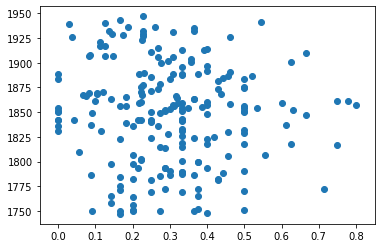

In [13]:
plt.scatter(fem_percents, play_years)

In [241]:
# let's add relative number of spoken words as an attribute for every role the play
for play in play_graph_dict:
    sum_of_words=0
    play_graph = play_graph_dict[play]
    sum_of_words = [int(play_graph.nodes[node]["Number of spoken words"]) for node in play_graph.nodes]
    sum_of_words = sum(sum_of_words)
    for node in play_graph.nodes:
        play_graph_dict[play].nodes()[node]['relative_num_of_words'] = round(play_graph.nodes[node]["Number of spoken words"]/sum_of_words, 6)

### Main/Supporting/Episodic markup.

In [242]:
# checking if we can add an attribute

In [243]:
play_graph_dict['gorky-na-dne'].nodes()["Akter"]

{'Person group': False,
 'Number of spoken words': 683,
 'Gender': 'MALE',
 'label': 'Актер',
 'importance': 'Lead',
 'relative_num_of_words': 0.053172}

In [244]:
play_graph_dict['gorky-na-dne'].nodes()["Akter"]["importance"] = "Lead"

In [245]:
play_graph_dict['gorky-na-dne'].nodes()["Akter"]["importance"] 

'Lead'

Markup of characters of 50 plays.
Sources of knowledge: summarys, Wiki description, skimming through the text of the play.

In [246]:
nodes_lengths = []

for x in play_graph_dict:
    nodes_lengths.append(len(play_graph_dict[x].nodes()))

(array([114.,  48.,  25.,   8.,   4.,   0.,   3.,   2.,   1.,   5.]),
 array([  2.,  12.,  22.,  32.,  42.,  52.,  62.,  72.,  82.,  92., 102.]),
 <a list of 10 Patch objects>)

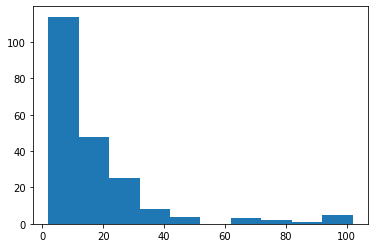

In [247]:
# distribution of character amount for plays
plt.hist(nodes_lengths)

In [248]:
X = 12
less_than_X = [x for x in nodes_lengths if x < X]
allover = len(nodes_lengths)

len(less_than_X) 

114

Let us analyze only relatively small graphs with 12 or less characters.

In [249]:
under_12_dict = {}
for x in play_graph_dict:
    if len(play_graph_dict[x].nodes()) < 12:
        under_12_dict[x] = play_graph_dict[x]

In [250]:
len(under_12_dict)

114

In [251]:
### beginning of exhausting mark-up
### it can be a good idea to CTRL-F-jump to the part "markup is finished"

In [252]:
dict_with_lead_markup = {}

In [253]:
#1 fonvizin-brigadir

In [254]:
under_12_dict["fonvizin-brigadir"].nodes()

NodeView(('sovetnik', 'syn', 'brigadir', 'sovetnitsa', 'brigadirsha', 'sofja', 'sluga', 'dobroljubov'))

In [255]:
play_graph_dict["fonvizin-brigadir"].nodes()["sovetnik"]["importance"] = "Lead"
play_graph_dict["fonvizin-brigadir"].nodes()["syn"]["importance"] = "Lead"
play_graph_dict["fonvizin-brigadir"].nodes()["brigadir"]["importance"] = "Lead"
play_graph_dict["fonvizin-brigadir"].nodes()["sovetnitsa"]["importance"] = "Lead"
play_graph_dict["fonvizin-brigadir"].nodes()["brigadirsha"]["importance"] = "Lead"
play_graph_dict["fonvizin-brigadir"].nodes()["sofja"]["importance"] = "Secondary"
play_graph_dict["fonvizin-brigadir"].nodes()["dobroljubov"]["importance"] = "Secondary"
play_graph_dict["fonvizin-brigadir"].nodes()["sluga"]["importance"] = "Episode"

In [256]:
dict_with_lead_markup["fonvizin-brigadir"] = play_graph_dict["fonvizin-brigadir"]

In [257]:
#2 mamin-sibirjak-zolotopromyshlenniki

In [258]:
under_12_dict["mamin-sibirjak-zolotopromyshlenniki"].nodes()

NodeView(('belonosov', 'shirinkin', 'anisja_tihonovna', 'vorotov', 'molokov', 'marfa_lukinishna', 'zasypkin', 'mosevna', 'lena', 'dasha', 'cheprakov'))

In [259]:
play_graph_dict["mamin-sibirjak-zolotopromyshlenniki"].nodes()["zasypkin"]["importance"] = "Lead"
play_graph_dict["mamin-sibirjak-zolotopromyshlenniki"].nodes()["anisja_tihonovna"]["importance"] = "Lead"
play_graph_dict["mamin-sibirjak-zolotopromyshlenniki"].nodes()["belonosov"]["importance"] = "Secondary" 
play_graph_dict["mamin-sibirjak-zolotopromyshlenniki"].nodes()["shirinkin"]["importance"] = "Secondary" 
play_graph_dict["mamin-sibirjak-zolotopromyshlenniki"].nodes()["vorotov"]["importance"] = "Secondary" 
play_graph_dict["mamin-sibirjak-zolotopromyshlenniki"].nodes()["molokov"]["importance"] = "Secondary" 
play_graph_dict["mamin-sibirjak-zolotopromyshlenniki"].nodes()["marfa_lukinishna"]["importance"] = "Secondary" 
play_graph_dict["mamin-sibirjak-zolotopromyshlenniki"].nodes()["lena"]["importance"] = "Secondary" 
play_graph_dict["mamin-sibirjak-zolotopromyshlenniki"].nodes()["cheprakov"]["importance"] = "Episode" 
play_graph_dict["mamin-sibirjak-zolotopromyshlenniki"].nodes()["mosevna"]["importance"] = "Episode" 
play_graph_dict["mamin-sibirjak-zolotopromyshlenniki"].nodes()["dasha"]["importance"] = "Episode" 

In [260]:
dict_with_lead_markup["mamin-sibirjak-zolotopromyshlenniki"] = play_graph_dict["mamin-sibirjak-zolotopromyshlenniki"]

In [261]:
#3 turgenev-zavtrak-u-predvoditelja

In [262]:
under_12_dict["turgenev-zavtrak-u-predvoditelja"].nodes()

NodeView(('mirvolin', 'gerasim', 'balagalaev', 'velvitskij', 'alupkin', 'suslov', 'kaurova', 'karp', 'bespandin', 'pehterev', 'naglanovich'))

In [263]:
play_graph_dict["turgenev-zavtrak-u-predvoditelja"].nodes()["balagalaev"]["importance"] = "Lead" 
play_graph_dict["turgenev-zavtrak-u-predvoditelja"].nodes()["mirvolin"]["importance"] = "Secondary" 
play_graph_dict["turgenev-zavtrak-u-predvoditelja"].nodes()["alupkin"]["importance"] = "Secondary" 
play_graph_dict["turgenev-zavtrak-u-predvoditelja"].nodes()["suslov"]["importance"] = "Secondary" 
play_graph_dict["turgenev-zavtrak-u-predvoditelja"].nodes()["kaurova"]["importance"] = "Secondary" 
play_graph_dict["turgenev-zavtrak-u-predvoditelja"].nodes()["bespandin"]["importance"] = "Secondary" 
play_graph_dict["turgenev-zavtrak-u-predvoditelja"].nodes()["pehterev"]["importance"] = "Secondary" 
play_graph_dict["turgenev-zavtrak-u-predvoditelja"].nodes()["naglanovich"]["importance"] = "Secondary" 
play_graph_dict["turgenev-zavtrak-u-predvoditelja"].nodes()["gerasim"]["importance"] = "Episode" 
play_graph_dict["turgenev-zavtrak-u-predvoditelja"].nodes()["velvitskij"]["importance"] = "Episode" 
play_graph_dict["turgenev-zavtrak-u-predvoditelja"].nodes()["karp"]["importance"] = "Episode" 

In [264]:
dict_with_lead_markup["turgenev-zavtrak-u-predvoditelja"] = play_graph_dict["turgenev-zavtrak-u-predvoditelja"]

In [265]:
#4 griboyedov-molodye-suprugi

In [266]:
under_12_dict["griboyedov-molodye-suprugi"].nodes()

NodeView(('arist', 'elmira', 'safir'))

In [267]:
play_graph_dict["griboyedov-molodye-suprugi"].nodes()["arist"]["importance"] = "Lead" 
play_graph_dict["griboyedov-molodye-suprugi"].nodes()["elmira"]["importance"] = "Lead" 
play_graph_dict["griboyedov-molodye-suprugi"].nodes()["safir"]["importance"] = "Lead" 

In [268]:
dict_with_lead_markup["griboyedov-molodye-suprugi"] = play_graph_dict["griboyedov-molodye-suprugi"]

In [269]:
#5 krylov-sonnyj-poroshok

In [270]:
under_12_dict["krylov-sonnyj-poroshok"].nodes()

NodeView(('blez', 'muzhiki', 'nineta', 'zhaneta', 'hor', 'zhuleta', 'rabotniki', 'graf', 'paulin', 'filipp'))

In [271]:
play_graph_dict["krylov-sonnyj-poroshok"].nodes()["blez"]["importance"] = "Secondary" 
play_graph_dict["krylov-sonnyj-poroshok"].nodes()["muzhiki"]["importance"] = "Group" 
play_graph_dict["krylov-sonnyj-poroshok"].nodes()["nineta"]["importance"] = "Episode" 
play_graph_dict["krylov-sonnyj-poroshok"].nodes()["zhaneta"]["importance"] = "Episode" 
play_graph_dict["krylov-sonnyj-poroshok"].nodes()["hor"]["importance"] = "Group" 
play_graph_dict["krylov-sonnyj-poroshok"].nodes()["zhuleta"]["importance"] = "Lead" 
play_graph_dict["krylov-sonnyj-poroshok"].nodes()["graf"]["importance"] = "Lead" 
play_graph_dict["krylov-sonnyj-poroshok"].nodes()["filipp"]["importance"] = "Lead" 
play_graph_dict["krylov-sonnyj-poroshok"].nodes()["paulin"]["importance"] = "Secondary" 
play_graph_dict["krylov-sonnyj-poroshok"].nodes()["rabotniki"]["importance"] = "Group" 

In [272]:
dict_with_lead_markup["krylov-sonnyj-poroshok"] = play_graph_dict["krylov-sonnyj-poroshok"]

In [273]:
#6 sollogub-chinovnik

In [274]:
under_12_dict["sollogub-chinovnik"].nodes()

NodeView(('strelskij_polkovnik', 'grafinja', 'mishorin', 'nadimov', 'sluga', 'drobinkin'))

In [275]:
play_graph_dict["sollogub-chinovnik"].nodes()["strelskij_polkovnik"]["importance"] = "Lead" 
play_graph_dict["sollogub-chinovnik"].nodes()["grafinja"]["importance"] = "Lead" 
play_graph_dict["sollogub-chinovnik"].nodes()["mishorin"]["importance"] = "Lead" 
play_graph_dict["sollogub-chinovnik"].nodes()["nadimov"]["importance"] = "Lead" 
play_graph_dict["sollogub-chinovnik"].nodes()["drobinkin"]["importance"] = "Secondary" 
play_graph_dict["sollogub-chinovnik"].nodes()["sluga"]["importance"] = "Episode"  

In [276]:
dict_with_lead_markup["sollogub-chinovnik"] = play_graph_dict["sollogub-chinovnik"]

In [277]:
#7 ostrovsky-nevolnicy

In [278]:
under_12_dict["ostrovsky-nevolnicy"].nodes()

NodeView(('miron', 'marfa', 'styrov', 'koblov', 'mulin', 'evlaliya', 'sofya'))

In [279]:
play_graph_dict["ostrovsky-nevolnicy"].nodes()["evlaliya"]["importance"] = "Lead" 
play_graph_dict["ostrovsky-nevolnicy"].nodes()["miron"]["importance"] = "Secondary" 
play_graph_dict["ostrovsky-nevolnicy"].nodes()["marfa"]["importance"] = "Secondary" 
play_graph_dict["ostrovsky-nevolnicy"].nodes()["styrov"]["importance"] = "Secondary" 
play_graph_dict["ostrovsky-nevolnicy"].nodes()["koblov"]["importance"] = "Secondary" 
play_graph_dict["ostrovsky-nevolnicy"].nodes()["mulin"]["importance"] = "Secondary"  
play_graph_dict["ostrovsky-nevolnicy"].nodes()["sofya"]["importance"] = "Secondary"   

In [280]:
dict_with_lead_markup["ostrovsky-nevolnicy"] = play_graph_dict["ostrovsky-nevolnicy"]

In [281]:
#8 prutkov-oprometchivyj-turka

In [282]:
under_12_dict["prutkov-oprometchivyj-turka"].nodes()

NodeView(('izvestnyj_pisatel', 'ivan_semenych', 'milovidov', 'kutilo-zavaldajskij', 'knyaz_batog-batyev', 'libental', 'razorvaki'))

In [283]:
play_graph_dict["prutkov-oprometchivyj-turka"].nodes()["ivan_semenych"]["importance"] = "Lead" 
play_graph_dict["prutkov-oprometchivyj-turka"].nodes()["izvestnyj_pisatel"]["importance"] = "Episode" 
play_graph_dict["prutkov-oprometchivyj-turka"].nodes()["milovidov"]["importance"] = "Secondary" 
play_graph_dict["prutkov-oprometchivyj-turka"].nodes()["kutilo-zavaldajskij"]["importance"] = "Secondary" 
play_graph_dict["prutkov-oprometchivyj-turka"].nodes()["knyaz_batog-batyev"]["importance"] = "Secondary" 
play_graph_dict["prutkov-oprometchivyj-turka"].nodes()["libental"]["importance"] = "Secondary" 
play_graph_dict["prutkov-oprometchivyj-turka"].nodes()["razorvaki"]["importance"] = "Secondary" 

In [284]:
dict_with_lead_markup["prutkov-oprometchivyj-turka"] = play_graph_dict["prutkov-oprometchivyj-turka"]

In [285]:
#9 ostrovsky-prazdnichnyj-son-do-obeda

In [286]:
under_12_dict["ostrovsky-prazdnichnyj-son-do-obeda"].nodes()

NodeView(('balzaminova', 'balzaminov', 'matrena', 'krasavina', 'nichkina', 'kapochka', 'ustinka', 'malanya', 'yusha', 'neuedenov'))

In [287]:
play_graph_dict["ostrovsky-prazdnichnyj-son-do-obeda"].nodes()["balzaminov"]["importance"] = "Lead" 
play_graph_dict["ostrovsky-prazdnichnyj-son-do-obeda"].nodes()["kapochka"]["importance"] = "Lead" 
play_graph_dict["ostrovsky-prazdnichnyj-son-do-obeda"].nodes()["balzaminova"]["importance"] = "Secondary" 
play_graph_dict["ostrovsky-prazdnichnyj-son-do-obeda"].nodes()["nichkina"]["importance"] = "Secondary" 
play_graph_dict["ostrovsky-prazdnichnyj-son-do-obeda"].nodes()["ustinka"]["importance"] = "Secondary" 
play_graph_dict["ostrovsky-prazdnichnyj-son-do-obeda"].nodes()["neuedenov"]["importance"] = "Secondary" 
play_graph_dict["ostrovsky-prazdnichnyj-son-do-obeda"].nodes()["neuedenov"]["importance"] = "Episode" 
play_graph_dict["ostrovsky-prazdnichnyj-son-do-obeda"].nodes()["matrena"]["importance"] = "Episode" 
play_graph_dict["ostrovsky-prazdnichnyj-son-do-obeda"].nodes()["malanya"]["importance"] = "Episode" 

In [288]:
dict_with_lead_markup["ostrovsky-prazdnichnyj-son-do-obeda"] = play_graph_dict["ostrovsky-prazdnichnyj-son-do-obeda"]

In [289]:
#10 khmelnitsky-vozdushnye-zamki

In [290]:
under_12_dict["khmelnitsky-vozdushnye-zamki"].nodes()

NodeView(('sasha', 'aglaeva', 'ipat', 'viktor', 'alnaskarov'))

In [291]:
play_graph_dict["khmelnitsky-vozdushnye-zamki"].nodes()["sasha"]["importance"] = "Lead" 
play_graph_dict["khmelnitsky-vozdushnye-zamki"].nodes()["aglaeva"]["importance"] = "Lead" 
play_graph_dict["khmelnitsky-vozdushnye-zamki"].nodes()["alnaskarov"]["importance"] = "Lead" 
play_graph_dict["khmelnitsky-vozdushnye-zamki"].nodes()["viktor"]["importance"] = "Lead" 
play_graph_dict["khmelnitsky-vozdushnye-zamki"].nodes()["ipat"]["importance"] = "Secondary" 

In [292]:
dict_with_lead_markup["khmelnitsky-vozdushnye-zamki"] = play_graph_dict["khmelnitsky-vozdushnye-zamki"]

In [293]:
#11 chekhov-djadja-vanja

In [294]:
under_12_dict["chekhov-djadja-vanja"].nodes()

NodeView(('marina', 'astrov', 'vojnitskij', 'serebrjakov', 'telegin', 'sonja', 'elena_andreevna', 'marija_vasilevna', 'rabotnik', 'golos_storozha'))

In [295]:
play_graph_dict["chekhov-djadja-vanja"].nodes()["vojnitskij"]["importance"] = "Lead"  
play_graph_dict["chekhov-djadja-vanja"].nodes()["astrov"]["importance"] = "Lead"  
play_graph_dict["chekhov-djadja-vanja"].nodes()["sonja"]["importance"] = "Lead"  
play_graph_dict["chekhov-djadja-vanja"].nodes()["serebrjakov"]["importance"] = "Secondary"  
play_graph_dict["chekhov-djadja-vanja"].nodes()["telegin"]["importance"] = "Secondary"  
play_graph_dict["chekhov-djadja-vanja"].nodes()["elena_andreevna"]["importance"] = "Secondary"  
play_graph_dict["chekhov-djadja-vanja"].nodes()["marija_vasilevna"]["importance"] = "Secondary"  
play_graph_dict["chekhov-djadja-vanja"].nodes()["rabotnik"]["importance"] = "Episode"  
play_graph_dict["chekhov-djadja-vanja"].nodes()["golos_storozha"]["importance"] = "Episode"  

In [296]:
dict_with_lead_markup["chekhov-djadja-vanja"] = play_graph_dict["chekhov-djadja-vanja"]

In [297]:
#12 pushkin-skupoj-rytsar

In [298]:
under_12_dict["pushkin-skupoj-rytsar"].nodes()

NodeView(('Alber', 'Ivan', 'Zhid', 'Baron', 'Gertsog'))

In [299]:
play_graph_dict["pushkin-skupoj-rytsar"].nodes()["Alber"]["importance"] = "Lead"  
play_graph_dict["pushkin-skupoj-rytsar"].nodes()["Baron"]["importance"] = "Lead"  
play_graph_dict["pushkin-skupoj-rytsar"].nodes()["Zhid"]["importance"] = "Secondary"  
play_graph_dict["pushkin-skupoj-rytsar"].nodes()["Gertsog"]["importance"] = "Secondary"  
play_graph_dict["pushkin-skupoj-rytsar"].nodes()["Ivan"]["importance"] = "Secondary"  

In [300]:
dict_with_lead_markup["pushkin-skupoj-rytsar"] = play_graph_dict["pushkin-skupoj-rytsar"]

In [301]:
#13 turgenev-gde-tonko-tam-i-rvetsja

In [302]:
under_12_dict["turgenev-gde-tonko-tam-i-rvetsja"].nodes()

NodeView(('gorskij', 'muhin', 'mademoiselle_bienaime', 'vera', 'gospozha_libanova', 'varvara_ivanovna', 'dvoretskij', 'chuhanov', 'sluga', 'stanitsyn'))

In [303]:
play_graph_dict["turgenev-gde-tonko-tam-i-rvetsja"].nodes()["gorskij"]["importance"] = "Lead"  
play_graph_dict["turgenev-gde-tonko-tam-i-rvetsja"].nodes()["vera"]["importance"] = "Lead"  
play_graph_dict["turgenev-gde-tonko-tam-i-rvetsja"].nodes()["stanitsyn"]["importance"] = "Lead"  
play_graph_dict["turgenev-gde-tonko-tam-i-rvetsja"].nodes()["muhin"]["importance"] = "Secondary"  
play_graph_dict["turgenev-gde-tonko-tam-i-rvetsja"].nodes()["mademoiselle_bienaime"]["importance"] = "Secondary"
play_graph_dict["turgenev-gde-tonko-tam-i-rvetsja"].nodes()["gospozha_libanova"]["importance"] = "Secondary"  
play_graph_dict["turgenev-gde-tonko-tam-i-rvetsja"].nodes()["varvara_ivanovna"]["importance"] = "Secondary"  
play_graph_dict["turgenev-gde-tonko-tam-i-rvetsja"].nodes()["dvoretskij"]["importance"] = "Episode"  
play_graph_dict["turgenev-gde-tonko-tam-i-rvetsja"].nodes()["sluga"]["importance"] = "Episode"  
play_graph_dict["turgenev-gde-tonko-tam-i-rvetsja"].nodes()["chuhanov"]["importance"] = "Episode"  

In [304]:
dict_with_lead_markup["turgenev-gde-tonko-tam-i-rvetsja"] = play_graph_dict["turgenev-gde-tonko-tam-i-rvetsja"]

In [305]:
#14 nikolev-samolyubivyj-stihotvorec

In [306]:
under_12_dict["nikolev-samolyubivyj-stihotvorec"].nodes()

NodeView(('panfil', 'marina', 'milana', 'nadmen', 'modstrih', 'naborshchik', 'kruton', 'chesnodum'))

In [307]:
play_graph_dict["nikolev-samolyubivyj-stihotvorec"].nodes()["nadmen"]["importance"] = "Lead"  
play_graph_dict["nikolev-samolyubivyj-stihotvorec"].nodes()["panfil"]["importance"] = "Secondary"  
play_graph_dict["nikolev-samolyubivyj-stihotvorec"].nodes()["marina"]["importance"] = "Secondary"  
play_graph_dict["nikolev-samolyubivyj-stihotvorec"].nodes()["milana"]["importance"] = "Secondary"  
play_graph_dict["nikolev-samolyubivyj-stihotvorec"].nodes()["modstrih"]["importance"] = "Secondary"
play_graph_dict["nikolev-samolyubivyj-stihotvorec"].nodes()["kruton"]["importance"] = "Secondary"
play_graph_dict["nikolev-samolyubivyj-stihotvorec"].nodes()["chesnodum"]["importance"] = "Secondary" 
play_graph_dict["nikolev-samolyubivyj-stihotvorec"].nodes()["naborshchik"]["importance"] = "Episode"

In [308]:
dict_with_lead_markup["nikolev-samolyubivyj-stihotvorec"] = play_graph_dict["nikolev-samolyubivyj-stihotvorec"]

In [309]:
#15 sumarokov-rogonosets-po-voobrazheniju

In [310]:
under_12_dict["sumarokov-rogonosets-po-voobrazheniju"].nodes()

NodeView(('nisa', 'eger', 'vikul', 'havronja', 'dvoretskij', 'floriza', 'kasandr'))

In [311]:
play_graph_dict["sumarokov-rogonosets-po-voobrazheniju"].nodes()["havronja"]["importance"] = "Lead"  
play_graph_dict["sumarokov-rogonosets-po-voobrazheniju"].nodes()["vikul"]["importance"] = "Lead"  
play_graph_dict["sumarokov-rogonosets-po-voobrazheniju"].nodes()["nisa"]["importance"] = "Secondary"  
play_graph_dict["sumarokov-rogonosets-po-voobrazheniju"].nodes()["eger"]["importance"] = "Secondary"  
play_graph_dict["sumarokov-rogonosets-po-voobrazheniju"].nodes()["dvoretskij"]["importance"] = "Secondary"  
play_graph_dict["sumarokov-rogonosets-po-voobrazheniju"].nodes()["floriza"]["importance"] = "Secondary"  
play_graph_dict["sumarokov-rogonosets-po-voobrazheniju"].nodes()["kasandr"]["importance"] = "Secondary"  

In [312]:
dict_with_lead_markup["sumarokov-rogonosets-po-voobrazheniju"] = play_graph_dict["sumarokov-rogonosets-po-voobrazheniju"]

In [313]:
#16 ostrovsky-neozhidannyj-sluchaj

In [314]:
under_12_dict["ostrovsky-neozhidannyj-sluchaj"].nodes()

NodeView(('rozovyj', 'druzhnin', 'sofya_antonovna', 'masha'))

In [315]:
play_graph_dict["ostrovsky-neozhidannyj-sluchaj"].nodes()["rozovyj"]["importance"] = "Lead"  
play_graph_dict["ostrovsky-neozhidannyj-sluchaj"].nodes()["druzhnin"]["importance"] = "Lead"  
play_graph_dict["ostrovsky-neozhidannyj-sluchaj"].nodes()["sofya_antonovna"]["importance"] = "Secondary"  
play_graph_dict["ostrovsky-neozhidannyj-sluchaj"].nodes()["masha"]["importance"] = "Episode"  

In [316]:
dict_with_lead_markup["ostrovsky-neozhidannyj-sluchaj"] = play_graph_dict["ostrovsky-neozhidannyj-sluchaj"]

In [317]:
#17 gogol-igroki

In [318]:
under_12_dict["gogol-igroki"].nodes()

NodeView(('aleksej', 'iharev', 'gavrjushka', 'krugel', 'shvohnev', 'uteshitelnyj', 'mihail_aleksandrovich_glov', 'aleksandr_mihalych_glov', 'zamuhryshkin'))

In [319]:
play_graph_dict["gogol-igroki"].nodes()["iharev"]["importance"] = "Lead"  
play_graph_dict["gogol-igroki"].nodes()["krugel"]["importance"] = "Secondary"  
play_graph_dict["gogol-igroki"].nodes()["shvohnev"]["importance"] = "Secondary"  
play_graph_dict["gogol-igroki"].nodes()["uteshitelnyj"]["importance"] = "Secondary"  
play_graph_dict["gogol-igroki"].nodes()["mihail_aleksandrovich_glov"]["importance"] = "Secondary"  
play_graph_dict["gogol-igroki"].nodes()["aleksandr_mihalych_glov"]["importance"] = "Secondary"  
play_graph_dict["gogol-igroki"].nodes()["zamuhryshkin"]["importance"] = "Episode"  
play_graph_dict["gogol-igroki"].nodes()["gavrjushka"]["importance"] = "Episode"  
play_graph_dict["gogol-igroki"].nodes()["aleksej"]["importance"] = "Episode"  

In [320]:
dict_with_lead_markup["gogol-igroki"] = play_graph_dict["gogol-igroki"]

In [321]:
#18 pushkin-kamenniy-gost

In [322]:
under_12_dict["pushkin-kamenniy-gost"].nodes()

NodeView(('don_guan', 'leporello', 'monah', 'dona_anna', 'pervyj_gost', 'vtoroj_gost', 'tretij_gost', 'laura', 'don_karlos', 'gost', 'statuja'))

In [323]:
play_graph_dict["pushkin-kamenniy-gost"].nodes()["don_guan"]["importance"] = "Lead" 
play_graph_dict["pushkin-kamenniy-gost"].nodes()["leporello"]["importance"] = "Secondary"   
play_graph_dict["pushkin-kamenniy-gost"].nodes()["dona_anna"]["importance"] = "Secondary"   
play_graph_dict["pushkin-kamenniy-gost"].nodes()["laura"]["importance"] = "Secondary"   
play_graph_dict["pushkin-kamenniy-gost"].nodes()["don_karlos"]["importance"] = "Secondary"   
play_graph_dict["pushkin-kamenniy-gost"].nodes()["statuja"]["importance"] = "Secondary"   
play_graph_dict["pushkin-kamenniy-gost"].nodes()["gost"]["importance"] = "Episode"   
play_graph_dict["pushkin-kamenniy-gost"].nodes()["monah"]["importance"] = "Episode"   
play_graph_dict["pushkin-kamenniy-gost"].nodes()["pervyj_gost"]["importance"] = "Episode"   
play_graph_dict["pushkin-kamenniy-gost"].nodes()["vtoroj_gost"]["importance"] = "Episode"   
play_graph_dict["pushkin-kamenniy-gost"].nodes()["tretij_gost"]["importance"] = "Episode"   

In [324]:
dict_with_lead_markup["pushkin-kamenniy-gost"] = play_graph_dict["pushkin-kamenniy-gost"]

In [325]:
#19 ostrovsky-semejnaya-kartina

In [326]:
under_12_dict["ostrovsky-semejnaya-kartina"].nodes()

NodeView(('marya_antipovna', 'matrena_savishna', 'darya', 'antip_antipych', 'stepanida_trofimovna', 'shiryalov'))

In [327]:
play_graph_dict["ostrovsky-semejnaya-kartina"].nodes()["antip_antipych"]["importance"] = "Lead" 
play_graph_dict["ostrovsky-semejnaya-kartina"].nodes()["marya_antipovna"]["importance"] = "Secondary"   
play_graph_dict["ostrovsky-semejnaya-kartina"].nodes()["matrena_savishna"]["importance"] = "Secondary" 
play_graph_dict["ostrovsky-semejnaya-kartina"].nodes()["stepanida_trofimovna"]["importance"] = "Secondary" 
play_graph_dict["ostrovsky-semejnaya-kartina"].nodes()["shiryalov"]["importance"] = "Secondary" 
play_graph_dict["ostrovsky-semejnaya-kartina"].nodes()["darya"]["importance"] = "Episode"    

In [328]:
dict_with_lead_markup["ostrovsky-semejnaya-kartina"] = play_graph_dict["ostrovsky-semejnaya-kartina"]

In [329]:
#20 pushkin-pir-vo-vremja-chumy

In [330]:
under_12_dict["pushkin-pir-vo-vremja-chumy"].nodes()

NodeView(('MolodojChelovek', 'Predsedatel', 'Meri', 'Luiza', 'Mnogie', 'Svjaschennik', 'ZhenskijGolos'))

In [331]:
play_graph_dict["pushkin-pir-vo-vremja-chumy"].nodes()["MolodojChelovek"]["importance"] = "Lead" 
play_graph_dict["pushkin-pir-vo-vremja-chumy"].nodes()["Predsedatel"]["importance"] = "Lead"   
play_graph_dict["pushkin-pir-vo-vremja-chumy"].nodes()["Meri"]["importance"] = "Lead" 
play_graph_dict["pushkin-pir-vo-vremja-chumy"].nodes()["Luiza"]["importance"] = "Lead" 
play_graph_dict["pushkin-pir-vo-vremja-chumy"].nodes()["Svjaschennik"]["importance"] = "Lead"  
play_graph_dict["pushkin-pir-vo-vremja-chumy"].nodes()["Mnogie"]["importance"] = "Group" 
play_graph_dict["pushkin-pir-vo-vremja-chumy"].nodes()["ZhenskijGolos"]["importance"] = "Episode"    

In [332]:
dict_with_lead_markup["pushkin-pir-vo-vremja-chumy"] = play_graph_dict["pushkin-pir-vo-vremja-chumy"]

In [333]:
#21 knyazhnin-traur

In [334]:
under_12_dict["knyazhnin-traur"].nodes()

NodeView(('evdokim', 'vetran', 'karachun', 'postan', 'milena', 'izabella'))

In [335]:
play_graph_dict["knyazhnin-traur"].nodes()["vetran"]["importance"] = "Lead" 
play_graph_dict["knyazhnin-traur"].nodes()["evdokim"]["importance"] = "Secondary" 
play_graph_dict["knyazhnin-traur"].nodes()["karachun"]["importance"] = "Secondary" 
play_graph_dict["knyazhnin-traur"].nodes()["postan"]["importance"] = "Secondary" 
play_graph_dict["knyazhnin-traur"].nodes()["milena"]["importance"] = "Secondary" 
play_graph_dict["knyazhnin-traur"].nodes()["izabella"]["importance"] = "Secondary" 

In [336]:
dict_with_lead_markup["knyazhnin-traur"] = play_graph_dict["knyazhnin-traur"]

In [337]:
#22 knyazhnin-rosslav

In [338]:
under_12_dict["knyazhnin-rosslav"].nodes()

NodeView(('adel', 'kedar', 'rosslav', 'zafira', 'lyubomir', 'hristiern'))

In [339]:
play_graph_dict["knyazhnin-rosslav"].nodes()["kedar"]["importance"] = "Lead" 
play_graph_dict["knyazhnin-rosslav"].nodes()["rosslav"]["importance"] = "Lead" 
play_graph_dict["knyazhnin-rosslav"].nodes()["zafira"]["importance"] = "Lead" 
play_graph_dict["knyazhnin-rosslav"].nodes()["lyubomir"]["importance"] = "Secondary" 
play_graph_dict["knyazhnin-rosslav"].nodes()["hristiern"]["importance"] = "Secondary" 
play_graph_dict["knyazhnin-rosslav"].nodes()["adel"]["importance"] = "Secondary" 

In [340]:
dict_with_lead_markup["knyazhnin-rosslav"] = play_graph_dict["knyazhnin-rosslav"]

In [341]:
#23 khmelnitsky-svetskiy-sluchay

In [342]:
under_12_dict["khmelnitsky-svetskiy-sluchay"].nodes()

NodeView(('evgeniya', 'dasha', 'radugin', 'stolicyn', 'ramirskij', 'evgenij'))

In [343]:
play_graph_dict["khmelnitsky-svetskiy-sluchay"].nodes()["stolicyn"]["importance"] = "Lead" 
play_graph_dict["khmelnitsky-svetskiy-sluchay"].nodes()["evgeniya"]["importance"] = "Lead" 
play_graph_dict["khmelnitsky-svetskiy-sluchay"].nodes()["ramirskij"]["importance"] = "Lead" 
play_graph_dict["khmelnitsky-svetskiy-sluchay"].nodes()["dasha"]["importance"] = "Secondary" 
play_graph_dict["khmelnitsky-svetskiy-sluchay"].nodes()["radugin"]["importance"] = "Secondary"
play_graph_dict["khmelnitsky-svetskiy-sluchay"].nodes()["evgenij"]["importance"] = "Secondary" 

In [344]:
dict_with_lead_markup["khmelnitsky-svetskiy-sluchay"] = play_graph_dict["khmelnitsky-svetskiy-sluchay"]

In [345]:
#24 ostrovsky-tyazhelye-dni

In [346]:
under_12_dict["ostrovsky-tyazhelye-dni"].nodes()

NodeView(('molodoj_chelovek', 'dosuzhev', 'percov', 'andrej_titych', 'aleksandra_petrovna', 'lusha', 'natalya_nikanorovna', 'nastasya_pankratevna', 'mudrov', 'tit_titych', 'neizvestnyj'))

In [347]:
play_graph_dict["ostrovsky-tyazhelye-dni"].nodes()["andrej_titych"]["importance"] = "Lead" 
play_graph_dict["ostrovsky-tyazhelye-dni"].nodes()["dosuzhev"]["importance"] = "Secondary" 
play_graph_dict["ostrovsky-tyazhelye-dni"].nodes()["aleksandra_petrovna"]["importabce"] = "Secondary" 
play_graph_dict["ostrovsky-tyazhelye-dni"].nodes()["percov"]["importance"] = "Secondary"  
play_graph_dict["ostrovsky-tyazhelye-dni"].nodes()["natalya_nikanorovna"]["importance"] = "Secondary" 
play_graph_dict["ostrovsky-tyazhelye-dni"].nodes()["nastasya_pankratevna"]["importance"] = "Secondary" 
play_graph_dict["ostrovsky-tyazhelye-dni"].nodes()["mudrov"]["importance"] = "Secondary" 
play_graph_dict["ostrovsky-tyazhelye-dni"].nodes()["tit_titych"]["importance"] = "Secondary" 
play_graph_dict["ostrovsky-tyazhelye-dni"].nodes()["neizvestnyj"]["importance"] = "Episode" 
play_graph_dict["ostrovsky-tyazhelye-dni"].nodes()["molodoj_chelovek"]["importance"] = "Episode" 
play_graph_dict["ostrovsky-tyazhelye-dni"].nodes()["lusha"]["importance"] = "Episode" 

In [348]:
dict_with_lead_markup["ostrovsky-tyazhelye-dni"] = play_graph_dict["ostrovsky-tyazhelye-dni"]

In [349]:
#25 sumarokov-sinav-i-truvor

In [350]:
under_12_dict["sumarokov-sinav-i-truvor"].nodes()

NodeView(('gostomysl', 'ilmena', 'sinav', 'truvor', 'pazh', 'vestnik'))

In [351]:
play_graph_dict["sumarokov-sinav-i-truvor"].nodes()["gostomysl"]["importance"] = "Lead" 
play_graph_dict["sumarokov-sinav-i-truvor"].nodes()["ilmena"]["importance"] = "Lead" 
play_graph_dict["sumarokov-sinav-i-truvor"].nodes()["sinav"]["importabce"] = "Lead" 
play_graph_dict["sumarokov-sinav-i-truvor"].nodes()["truvor"]["importance"] = "Lead"  
play_graph_dict["sumarokov-sinav-i-truvor"].nodes()["pazh"]["importance"] = "Episode" 
play_graph_dict["sumarokov-sinav-i-truvor"].nodes()["vestnik"]["importance"] = "Episode" 

In [352]:
dict_with_lead_markup["sumarokov-sinav-i-truvor"] = play_graph_dict["sumarokov-sinav-i-truvor"]

In [353]:
#26 kropotov-fomushka

In [354]:
under_12_dict["kropotov-fomushka"].nodes()

NodeView(('mitrofan', 'havronia', 'karpovich', 'foma', 'marina', 'graf', 'dobrovidov', 'ostromyslov', 'malania', 'notarius'))

In [355]:
play_graph_dict["kropotov-fomushka"].nodes()["havronia"]["importance"] = "Lead"  
play_graph_dict["kropotov-fomushka"].nodes()["foma"]["importance"] = "Lead"  
play_graph_dict["kropotov-fomushka"].nodes()["graf"]["importance"] = "Lead"  
play_graph_dict["kropotov-fomushka"].nodes()["ostromyslov"]["importance"] = "Lead"  
play_graph_dict["kropotov-fomushka"].nodes()["dobrovidov"]["importance"] = "Lead"  
play_graph_dict["kropotov-fomushka"].nodes()["malania"]["importance"] = "Secondary"  
play_graph_dict["kropotov-fomushka"].nodes()["marina"]["importance"] = "Secondary"  
play_graph_dict["kropotov-fomushka"].nodes()["karpovich"]["importance"] = "Secondary"  
play_graph_dict["kropotov-fomushka"].nodes()["notarius"]["importance"] = "Episode"  
play_graph_dict["kropotov-fomushka"].nodes()["mitrofan"]["importance"] = "Episode"  

In [356]:
dict_with_lead_markup["kropotov-fomushka"] = play_graph_dict["kropotov-fomushka"]

In [357]:
#27 ostrovsky-utro-molodogo-cheloveka

In [358]:
under_12_dict["ostrovsky-utro-molodogo-cheloveka"].nodes()

NodeView(('ivan', 'sidorych', 'grishka', 'lisavskij', 'vtoroj_molodoj_chelovek', 'pervyj_molodoj_chelovek', 'nedopekin', 'smurov', 'vasya'))

In [359]:
play_graph_dict["ostrovsky-utro-molodogo-cheloveka"].nodes()["lisavskij"]["importance"] = "Lead"  
play_graph_dict["ostrovsky-utro-molodogo-cheloveka"].nodes()["nedopekin"]["importance"] = "Lead"  
play_graph_dict["ostrovsky-utro-molodogo-cheloveka"].nodes()["ivan"]["importance"] = "Secondary"  
play_graph_dict["ostrovsky-utro-molodogo-cheloveka"].nodes()["vtoroj_molodoj_chelovek"]["importance"] = "Secondary" 
play_graph_dict["ostrovsky-utro-molodogo-cheloveka"].nodes()["smurov"]["importance"] = "Secondary"  
play_graph_dict["ostrovsky-utro-molodogo-cheloveka"].nodes()["pervyj_molodoj_chelovek"]["importance"] = "Secondary" 
play_graph_dict["ostrovsky-utro-molodogo-cheloveka"].nodes()["vasya"]["importance"] = "Episode"  
play_graph_dict["ostrovsky-utro-molodogo-cheloveka"].nodes()["sidorych"]["importance"] = "Episode"  
play_graph_dict["ostrovsky-utro-molodogo-cheloveka"].nodes()["grishka"]["importance"] = "Episode"  

In [360]:
dict_with_lead_markup["ostrovsky-utro-molodogo-cheloveka"] = play_graph_dict["ostrovsky-utro-molodogo-cheloveka"]

In [361]:
#28 krylov-pirog

In [362]:
under_12_dict["krylov-pirog"].nodes()

NodeView(('vanka', 'muzhik', 'dasha', 'fatyuev', 'uzhima', 'prelesta', 'milon', 'vspyshkin', 'potap'))

In [363]:
play_graph_dict["krylov-pirog"].nodes()["vspyshkin"]["importance"] = "Lead"
play_graph_dict["krylov-pirog"].nodes()["uzhima"]["importance"] = "Lead"
play_graph_dict["krylov-pirog"].nodes()["vanka"]["importance"] = "Secondary"
play_graph_dict["krylov-pirog"].nodes()["fatyuev"]["importance"] = "Secondary"
play_graph_dict["krylov-pirog"].nodes()["dasha"]["importance"] = "Secondary"
play_graph_dict["krylov-pirog"].nodes()["prelesta"]["importance"] = "Secondary" 
play_graph_dict["krylov-pirog"].nodes()["milon"]["importance"] = "Secondary"
play_graph_dict["krylov-pirog"].nodes()["potap"]["importance"] = "Episode"
play_graph_dict["krylov-pirog"].nodes()["muzhik"]["importance"] = "Episode"

In [364]:
dict_with_lead_markup["krylov-pirog"] = play_graph_dict["krylov-pirog"]

In [365]:
#29 knyazhnin-hvastun

In [366]:
under_12_dict["knyazhnin-hvastun"].nodes()

NodeView(('polist', 'prostodum', 'portnoj', 'verholet', 'marina', 'chvankina', 'milena', 'prikazchik', 'zamir', 'cheston', 'blagochinnyj'))

In [367]:
play_graph_dict["knyazhnin-hvastun"].nodes()["verholet"]["importance"] = "Lead"
play_graph_dict["knyazhnin-hvastun"].nodes()["polist"]["importance"] = "Lead"
play_graph_dict["knyazhnin-hvastun"].nodes()["prostodum"]["importance"] = "Secondary"
play_graph_dict["knyazhnin-hvastun"].nodes()["marina"]["importance"] = "Secondary"
play_graph_dict["knyazhnin-hvastun"].nodes()["chvankina"]["importance"] = "Secondary"
play_graph_dict["knyazhnin-hvastun"].nodes()["milena"]["importance"] = "Secondary"
play_graph_dict["knyazhnin-hvastun"].nodes()["zamir"]["importance"] = "Secondary"
play_graph_dict["knyazhnin-hvastun"].nodes()["cheston"]["importance"] = "Secondary"
play_graph_dict["knyazhnin-hvastun"].nodes()["blagochinnyj"]["importance"] = "Episode"
play_graph_dict["knyazhnin-hvastun"].nodes()["prikazchik"]["importance"] = "Episode"
play_graph_dict["knyazhnin-hvastun"].nodes()["portnoj"]["importance"] = "Episode"

In [368]:
dict_with_lead_markup["knyazhnin-hvastun"] = play_graph_dict["knyazhnin-hvastun"]

In [369]:
#30 nekrasov-junost-lomonosova

In [370]:
under_12_dict["nekrasov-junost-lomonosova"].nodes()

NodeView(('starik', 'zhenschina', 'mihail_lomonosov', 'izvozchik'))

In [371]:
play_graph_dict["nekrasov-junost-lomonosova"].nodes()["mihail_lomonosov"]["importance"] = "Lead"
play_graph_dict["nekrasov-junost-lomonosova"].nodes()["starik"]["importance"] = "Secondary"
play_graph_dict["nekrasov-junost-lomonosova"].nodes()["zhenschina"]["importance"] = "Secondary"
play_graph_dict["nekrasov-junost-lomonosova"].nodes()["izvozchik"]["importance"] = "Episode"

In [372]:
dict_with_lead_markup["nekrasov-junost-lomonosova"] = play_graph_dict["nekrasov-junost-lomonosova"]

In [373]:
#31 sumarokov-gamlet

In [374]:
under_12_dict["sumarokov-gamlet"].nodes()

NodeView(('gamlet', 'armans', 'gertruda', 'klavdij', 'polonij', 'ratuda', 'ofelija', 'flemina', 'nachalnik_strazhi', 'voin'))

In [375]:
play_graph_dict["sumarokov-gamlet"].nodes()["gamlet"]["importance"] = "Lead"
play_graph_dict["sumarokov-gamlet"].nodes()["polonij"]["importance"] = "Lead"
play_graph_dict["sumarokov-gamlet"].nodes()["ofelija"]["importance"] = "Lead"
play_graph_dict["sumarokov-gamlet"].nodes()["gertruda"]["importance"] = "Secondary"
play_graph_dict["sumarokov-gamlet"].nodes()["klavdij"]["importance"] = "Secondary" 
play_graph_dict["sumarokov-gamlet"].nodes()["flemina"]["importance"] = "Episode"
play_graph_dict["sumarokov-gamlet"].nodes()["armans"]["importance"] = "Episode"
play_graph_dict["sumarokov-gamlet"].nodes()["ratuda"]["importance"] = "Episode"
play_graph_dict["sumarokov-gamlet"].nodes()["nachalnik_strazhi"]["importance"] = "Episode"
play_graph_dict["sumarokov-gamlet"].nodes()["voin"]["importance"] = "Episode"

In [376]:
dict_with_lead_markup["sumarokov-gamlet"] = play_graph_dict["sumarokov-gamlet"]

In [377]:
#32 ostrovsky-bogatye-nevesty

In [378]:
under_12_dict["ostrovsky-bogatye-nevesty"].nodes()

NodeView(('bedonegova', 'piramidalov', 'gnevyshov', 'belesova', 'cyplunova', 'cyplunov'))

In [379]:
play_graph_dict["ostrovsky-bogatye-nevesty"].nodes()["bedonegova"]["importance"] = "Lead"
play_graph_dict["ostrovsky-bogatye-nevesty"].nodes()["piramidalov"]["importance"] = "Lead"
play_graph_dict["ostrovsky-bogatye-nevesty"].nodes()["gnevyshov"]["importance"] = "Lead"
play_graph_dict["ostrovsky-bogatye-nevesty"].nodes()["belesova"]["importance"] = "Lead"
play_graph_dict["ostrovsky-bogatye-nevesty"].nodes()["cyplunova"]["importance"] = "Lead"
play_graph_dict["ostrovsky-bogatye-nevesty"].nodes()["cyplunov"]["importance"] = "Lead"

In [380]:
dict_with_lead_markup["ostrovsky-bogatye-nevesty"] = play_graph_dict["ostrovsky-bogatye-nevesty"]

In [381]:
#33 chekhov-predlozhenie

In [382]:
under_12_dict["chekhov-predlozhenie"].nodes()

NodeView(('chubukov', 'lomov', 'natalja_stepanovna'))

In [383]:
play_graph_dict["chekhov-predlozhenie"].nodes()["chubukov"]["importance"] = "Lead"
play_graph_dict["chekhov-predlozhenie"].nodes()["lomov"]["importance"] = "Lead"
play_graph_dict["chekhov-predlozhenie"].nodes()["natalja_stepanovna"]["importance"] = "Lead"

In [384]:
dict_with_lead_markup["chekhov-predlozhenie"] = play_graph_dict["chekhov-predlozhenie"]

In [385]:
#34 sumarokov-tresotinius

In [386]:
under_12_dict["sumarokov-tresotinius"].nodes()

NodeView(('klarisa', 'oront', 'tresotinius', 'bobembius', 'kimar', 'bramarbas', 'serzhant', 'podjachij', 'erast', 'ksaksoksimenius', 'dorant'))

In [387]:
play_graph_dict["sumarokov-tresotinius"].nodes()["tresotinius"]["importance"] = "Lead"
play_graph_dict["sumarokov-tresotinius"].nodes()["oront"]["importance"] = "Secondary"
play_graph_dict["sumarokov-tresotinius"].nodes()["klarisa"]["importance"] = "Secondary"
play_graph_dict["sumarokov-tresotinius"].nodes()["bobembius"]["importance"] = "Secondary"
play_graph_dict["sumarokov-tresotinius"].nodes()["kimar"]["importance"] = "Secondary"
play_graph_dict["sumarokov-tresotinius"].nodes()["bramarbas"]["importance"] = "Secondary"
play_graph_dict["sumarokov-tresotinius"].nodes()["erast"]["importance"] = "Secondary"
play_graph_dict["sumarokov-tresotinius"].nodes()["podjachij"]["importance"] = "Secondary"
play_graph_dict["sumarokov-tresotinius"].nodes()["serzhant"]["importance"] = "Episode"
play_graph_dict["sumarokov-tresotinius"].nodes()["dorant"]["importance"] = "Episode"
play_graph_dict["sumarokov-tresotinius"].nodes()["ksaksoksimenius"]["importance"] = "Episode"

In [388]:
dict_with_lead_markup["sumarokov-tresotinius"] = play_graph_dict["sumarokov-tresotinius"]

In [389]:
#35 nekrasov-zabrakovannye

In [390]:
under_12_dict["nekrasov-zabrakovannye"].nodes()

NodeView(('grigoriy', 'pervaya_devushka', 'vtoraya_devushka', 'tretya_devushka', 'triumviratov', 'kalistratka', 'kharchin', 'tuzov', 'kadykov'))

In [391]:
play_graph_dict["nekrasov-zabrakovannye"].nodes()["grigoriy"]["importance"] = "Lead"
play_graph_dict["nekrasov-zabrakovannye"].nodes()["triumviratov"]["importance"] = "Lead"
play_graph_dict["nekrasov-zabrakovannye"].nodes()["kalistratka"]["importance"] = "Secondary"
play_graph_dict["nekrasov-zabrakovannye"].nodes()["kadykov"]["importance"] = "Secondary"
play_graph_dict["nekrasov-zabrakovannye"].nodes()["tuzov"]["importance"] = "Secondary"
play_graph_dict["nekrasov-zabrakovannye"].nodes()["kharchin"]["importance"] = "Secondary"
play_graph_dict["nekrasov-zabrakovannye"].nodes()["tretya_devushka"]["importance"] = "Episode"
play_graph_dict["nekrasov-zabrakovannye"].nodes()["vtoraya_devushka"]["importance"] = "Episode"
play_graph_dict["nekrasov-zabrakovannye"].nodes()["pervaya_devushka"]["importance"] = "Episode"

In [392]:
dict_with_lead_markup["nekrasov-zabrakovannye"] = play_graph_dict["nekrasov-zabrakovannye"]

In [393]:
#36 gogol-utro-delovogo-cheloveka

In [394]:
under_12_dict["gogol-utro-delovogo-cheloveka"].nodes()

NodeView(('ivan_petrovich', 'lakej', 'aleksandr_ivanovich', 'shrejder', 'katerina_aleksandrovna'))

In [395]:
play_graph_dict["gogol-utro-delovogo-cheloveka"].nodes()["aleksandr_ivanovich"]["importance"] = "Lead"
play_graph_dict["gogol-utro-delovogo-cheloveka"].nodes()["ivan_petrovich"]["importance"] = "Lead"
play_graph_dict["gogol-utro-delovogo-cheloveka"].nodes()["shrejder"]["importance"] = "Episode"
play_graph_dict["gogol-utro-delovogo-cheloveka"].nodes()["lakej"]["importance"] = "Episode"
play_graph_dict["gogol-utro-delovogo-cheloveka"].nodes()["katerina_aleksandrovna"]["importance"] = "Episode"

In [396]:
dict_with_lead_markup["gogol-utro-delovogo-cheloveka"] = play_graph_dict["gogol-utro-delovogo-cheloveka"]

In [397]:
#37 shakhovskoy-ne-lubo-ne-slushai

In [398]:
under_12_dict["shakhovskoy-ne-lubo-ne-slushai"].nodes()

NodeView(('zarnitskin', 'dashenka', 'mitjaj', 'mezetskij', 'knjaginja', 'handrina'))

In [399]:
play_graph_dict["shakhovskoy-ne-lubo-ne-slushai"].nodes()["zarnitskin"]["importance"] = "Lead"
play_graph_dict["shakhovskoy-ne-lubo-ne-slushai"].nodes()["mezetskij"]["importance"] = "Lead"
play_graph_dict["shakhovskoy-ne-lubo-ne-slushai"].nodes()["mitjaj"]["importance"] = "Secondary"
play_graph_dict["shakhovskoy-ne-lubo-ne-slushai"].nodes()["dashenka"]["importance"] = "Secondary"
play_graph_dict["shakhovskoy-ne-lubo-ne-slushai"].nodes()["knjaginja"]["importance"] = "Secondary"
play_graph_dict["shakhovskoy-ne-lubo-ne-slushai"].nodes()["handrina"]["importance"] = "Secondary"

In [400]:
dict_with_lead_markup["shakhovskoy-ne-lubo-ne-slushai"] = play_graph_dict["shakhovskoy-ne-lubo-ne-slushai"]

In [401]:
#38 gogol-tjazhba

In [402]:
under_12_dict["gogol-tjazhba"].nodes()

NodeView(('proletov', 'lakej', 'burdjukov'))

In [403]:
play_graph_dict["gogol-tjazhba"].nodes()["proletov"]["importance"] = "Lead"
play_graph_dict["gogol-tjazhba"].nodes()["burdjukov"]["importance"] = "Lead"
play_graph_dict["gogol-tjazhba"].nodes()["lakej"]["importance"] = "Episode"

In [404]:
dict_with_lead_markup["gogol-tjazhba"] = play_graph_dict["gogol-tjazhba"]

In [405]:
#39 turgenev-provintsialka

In [406]:
under_12_dict["turgenev-provintsialka"].nodes()

NodeView(('darja_ivanovna', 'misha', 'stupendev', 'vasilevna', 'apollon', 'lakej', 'graf_ljubin'))

In [407]:
play_graph_dict["turgenev-provintsialka"].nodes()["darja_ivanovna"]["importance"] = "Lead"
play_graph_dict["turgenev-provintsialka"].nodes()["stupendev"]["importance"] = "Lead"
play_graph_dict["turgenev-provintsialka"].nodes()["graf_ljubin"]["importance"] = "Lead"
play_graph_dict["turgenev-provintsialka"].nodes()["misha"]["importance"] = "Secondary"
play_graph_dict["turgenev-provintsialka"].nodes()["vasilevna"]["importance"] = "Episode"
play_graph_dict["turgenev-provintsialka"].nodes()["apollon"]["importance"] = "Episode"
play_graph_dict["turgenev-provintsialka"].nodes()["lakej"]["importance"] = "Episode"

In [408]:
dict_with_lead_markup["turgenev-provintsialka"] = play_graph_dict["turgenev-provintsialka"]

In [409]:
#40 majkov-femist-i-ieronima

In [410]:
under_12_dict["majkov-femist-i-ieronima"].nodes()

NodeView(('klit', 'femist', 'magomet', 'osman', 'ieronima', 'nachalnik'))

In [411]:
play_graph_dict["majkov-femist-i-ieronima"].nodes()["femist"]["importance"] = "Lead"
play_graph_dict["majkov-femist-i-ieronima"].nodes()["magomet"]["importance"] = "Lead"
play_graph_dict["majkov-femist-i-ieronima"].nodes()["ieronima"]["importance"] = "Lead"
play_graph_dict["majkov-femist-i-ieronima"].nodes()["klit"]["importance"] = "Secondary"
play_graph_dict["majkov-femist-i-ieronima"].nodes()["osman"]["importance"] = "Secondary" 
play_graph_dict["majkov-femist-i-ieronima"].nodes()["nachalnik"]["importance"] = "Episode"

In [412]:
dict_with_lead_markup["majkov-femist-i-ieronima"] = play_graph_dict["majkov-femist-i-ieronima"]

In [413]:
#41 knyazhnin-vadim-novgorodskij

In [414]:
under_12_dict["knyazhnin-vadim-novgorodskij"].nodes()

NodeView(('vigor', 'prenest', 'vadim', 'selena', 'ramida', 'rurik', 'izved'))

In [415]:
play_graph_dict["knyazhnin-vadim-novgorodskij"].nodes()["vadim"]["importance"] = "Lead"
play_graph_dict["knyazhnin-vadim-novgorodskij"].nodes()["ramida"]["importance"] = "Lead"
play_graph_dict["knyazhnin-vadim-novgorodskij"].nodes()["rurik"]["importance"] = "Lead"
play_graph_dict["knyazhnin-vadim-novgorodskij"].nodes()["prenest"]["importance"] = "Secondary"
play_graph_dict["knyazhnin-vadim-novgorodskij"].nodes()["vigor"]["importance"] = "Secondary" 
play_graph_dict["knyazhnin-vadim-novgorodskij"].nodes()["selena"]["importance"] = "Episode"
play_graph_dict["knyazhnin-vadim-novgorodskij"].nodes()["izved"]["importance"] = "Episode"

In [416]:
dict_with_lead_markup["knyazhnin-vadim-novgorodskij"] = play_graph_dict["knyazhnin-vadim-novgorodskij"]

In [417]:
#42 khmelnitsky-vzaimnye-ispytaniya

In [418]:
under_12_dict["khmelnitsky-vzaimnye-ispytaniya"].nodes()

NodeView(('grafinya', 'svetlana', 'plamirskij', 'ehledin'))

In [419]:
play_graph_dict["khmelnitsky-vzaimnye-ispytaniya"].nodes()["grafinya"]["importance"] = "Lead"
play_graph_dict["khmelnitsky-vzaimnye-ispytaniya"].nodes()["svetlana"]["importance"] = "Lead"
play_graph_dict["khmelnitsky-vzaimnye-ispytaniya"].nodes()["plamirskij"]["importance"] = "Lead"
play_graph_dict["khmelnitsky-vzaimnye-ispytaniya"].nodes()["ehledin"]["importance"] = "Secondary"

In [420]:
dict_with_lead_markup["khmelnitsky-vzaimnye-ispytaniya"] = play_graph_dict["khmelnitsky-vzaimnye-ispytaniya"]

In [421]:
#43 chekhov-tragik-ponevole

In [422]:
under_12_dict["chekhov-tragik-ponevole"].nodes()

NodeView(('Murashkin', 'Tolkachov'))

In [423]:
play_graph_dict["chekhov-tragik-ponevole"].nodes()["Murashkin"]["importance"] = "Lead"
play_graph_dict["chekhov-tragik-ponevole"].nodes()["Tolkachov"]["importance"] = "Lead"

In [424]:
dict_with_lead_markup["chekhov-tragik-ponevole"] = play_graph_dict["chekhov-tragik-ponevole"]

In [425]:
len(dict_with_lead_markup)

43

In [426]:
#44 turgenev-vecher-v-sorrente

In [427]:
under_12_dict["turgenev-vecher-v-sorrente"].nodes()

NodeView(('avakov', 'sluga', 'mr_popelin', 'nadezhda_pavlovna', 'belskij', 'marija_petrovna', 'golos_pevtsa'))

In [428]:
play_graph_dict["turgenev-vecher-v-sorrente"].nodes()["avakov"]["importance"] = "Lead"
play_graph_dict["turgenev-vecher-v-sorrente"].nodes()["nadezhda_pavlovna"]["importance"] = "Lead"
play_graph_dict["turgenev-vecher-v-sorrente"].nodes()["belskij"]["importance"] = "Lead"
play_graph_dict["turgenev-vecher-v-sorrente"].nodes()["marija_petrovna"]["importance"] = "Lead"
play_graph_dict["turgenev-vecher-v-sorrente"].nodes()["golos_pevtsa"]["importance"] = "Episode" 
play_graph_dict["turgenev-vecher-v-sorrente"].nodes()["sluga"]["importance"] = "Episode"
play_graph_dict["turgenev-vecher-v-sorrente"].nodes()["mr_popelin"]["importance"] = "Episode"

In [429]:
dict_with_lead_markup["turgenev-vecher-v-sorrente"] = play_graph_dict["turgenev-vecher-v-sorrente"]

In [430]:
#45 ostrovsky-bez-viny-vinovatye

In [431]:
under_12_dict["sumarokov-vzdorschitsa"].nodes()

NodeView(('burda', 'finetta', 'rozmarin', 'durak', 'asir', 'erast', 'rozalija', 'vorozheja'))

In [432]:
play_graph_dict["sumarokov-vzdorschitsa"].nodes()["burda"]["importance"] = "Lead"
play_graph_dict["sumarokov-vzdorschitsa"].nodes()["finetta"]["importance"] = "Lead"
play_graph_dict["sumarokov-vzdorschitsa"].nodes()["rozmarin"]["importance"] = "Lead"
play_graph_dict["sumarokov-vzdorschitsa"].nodes()["asir"]["importance"] = "Lead"
play_graph_dict["sumarokov-vzdorschitsa"].nodes()["rozalija"]["importance"] = "Lead" 
play_graph_dict["sumarokov-vzdorschitsa"].nodes()["vorozheja"]["importance"] = "Secondary"
play_graph_dict["sumarokov-vzdorschitsa"].nodes()["erast"]["importance"] = "Secondary"

In [433]:
dict_with_lead_markup["sumarokov-vzdorschitsa"] = play_graph_dict["sumarokov-vzdorschitsa"]

In [434]:
#46 majkov-agriopa

In [435]:
under_12_dict["majkov-agriopa"].nodes()

NodeView(('albina', 'agriopa', 'telef', 'voenachalnik', 'ariston', 'azor', 'odin_voin', 'vestnik'))

In [436]:
play_graph_dict["majkov-agriopa"].nodes()["agriopa"]["importance"] = "Lead"
play_graph_dict["majkov-agriopa"].nodes()["telef"]["importance"] = "Lead"
play_graph_dict["majkov-agriopa"].nodes()["azor"]["importance"] = "Lead"
play_graph_dict["majkov-agriopa"].nodes()["albina"]["importance"] = "Secondary"
play_graph_dict["majkov-agriopa"].nodes()["ariston"]["importance"] = "Secondary" 
play_graph_dict["majkov-agriopa"].nodes()["vestnik"]["importance"] = "Episode" 
play_graph_dict["majkov-agriopa"].nodes()["odin_voin"]["importance"] = "Episode"
play_graph_dict["majkov-agriopa"].nodes()["voenachalnik"]["importance"] = "Episode"

In [437]:
dict_with_lead_markup["majkov-agriopa"] = play_graph_dict["majkov-agriopa"]

In [438]:
#47 chekhov-medved

In [439]:
under_12_dict["chekhov-medved"].nodes()

NodeView(('Luka', 'Popova', 'Smirnov'))

In [440]:
play_graph_dict["chekhov-medved"].nodes()["Smirnov"]["importance"] = "Lead"
play_graph_dict["chekhov-medved"].nodes()["Popova"]["importance"] = "Lead"
play_graph_dict["chekhov-medved"].nodes()["Luka"]["importance"] = "Secondary"

In [441]:
dict_with_lead_markup["chekhov-medved"] = play_graph_dict["chekhov-medved"]

In [442]:
#48 chekhov-jubilej

In [443]:
under_12_dict["chekhov-jubilej"].nodes()

NodeView(('Hirin', 'Shipuchin', 'TatjanaAlekseevna', 'Merchutkina', 'ChlenBanka'))

In [444]:
play_graph_dict["chekhov-jubilej"].nodes()["Hirin"]["importance"] = "Lead"
play_graph_dict["chekhov-jubilej"].nodes()["Shipuchin"]["importance"] = "Lead"
play_graph_dict["chekhov-jubilej"].nodes()["TatjanaAlekseevna"]["importance"] = "Lead"
play_graph_dict["chekhov-jubilej"].nodes()["Merchutkina"]["importance"] = "Lead" 
play_graph_dict["chekhov-jubilej"].nodes()["ChlenBanka"]["importance"] = "Episode"

In [445]:
dict_with_lead_markup["chekhov-jubilej"] = play_graph_dict["chekhov-jubilej"]

In [446]:
#49 lensky-horosha-i-durna

In [447]:
under_12_dict["lensky-horosha-i-durna"].nodes()

NodeView(('konstantin_prohorovich', 'stepanida_karpovna', 'padcheretsin', 'nadenka', 'emeljan', 'alinskoj'))

In [448]:
play_graph_dict["lensky-horosha-i-durna"].nodes()["konstantin_prohorovich"]["importance"] = "Lead" 
play_graph_dict["lensky-horosha-i-durna"].nodes()["stepanida_karpovna"]["importance"] = "Lead" 
play_graph_dict["lensky-horosha-i-durna"].nodes()["padcheretsin"]["importance"] = "Lead" 
play_graph_dict["lensky-horosha-i-durna"].nodes()["nadenka"]["importance"] = "Lead" 
play_graph_dict["lensky-horosha-i-durna"].nodes()["alinskoj"]["importance"] = "Lead" 
play_graph_dict["lensky-horosha-i-durna"].nodes()["emeljan"]["importance"] = "Episode" 

In [449]:
#50 turgenev-holostjak

In [450]:
under_12_dict["nekrasov-akter"].nodes()

NodeView(('kochergin', 'suhozilov', 'lidia', 'strujkin', 'suhozilova', 'tatarin', 'italianets', 'sluga'))

In [451]:
play_graph_dict["nekrasov-akter"].nodes()["kochergin"]["importance"] = "Lead" 
play_graph_dict["nekrasov-akter"].nodes()["suhozilov"]["importance"] = "Lead" 
play_graph_dict["nekrasov-akter"].nodes()["strujkin"]["importance"] = "Lead" 
play_graph_dict["nekrasov-akter"].nodes()["suhozilova"]["importance"] = "Secondary" 
play_graph_dict["nekrasov-akter"].nodes()["lidia"]["importance"] = "Secondary" 
play_graph_dict["nekrasov-akter"].nodes()["sluga"]["importance"] = "Episode" 
play_graph_dict["nekrasov-akter"].nodes()["italianets"]["importance"] = "Episode" 
play_graph_dict["nekrasov-akter"].nodes()["tatarin"]["importance"] = "Episode" 
# сложный случай: трое персонажей -- один

In [452]:
# markup is finished

### Analyzing "importance tags"

In [453]:
play_graph_dict["majkov-agriopa"].nodes()["agriopa"]

{'Person group': False,
 'Number of spoken words': 3305,
 'Gender': 'FEMALE',
 'label': 'Агриопа',
 'importance': 'Lead',
 'relative_num_of_words': 0.375696}

In [454]:
labels = nx.get_node_attributes(play_graph_dict["majkov-agriopa"], 'label')

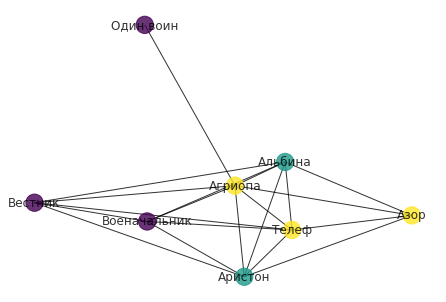

In [455]:
my_pos = nx.circular_layout(play_graph_dict["majkov-agriopa"]) 
plt.figure() 

val_map = {"Lead": 1, "Secondary": 0.54, "Episode": 0} 
values = [val_map.get(play_graph_dict["majkov-agriopa"].nodes()[node]["importance"], 0.25) 
          for node in play_graph_dict["majkov-agriopa"].nodes()]

nx.draw_spring(play_graph_dict["majkov-agriopa"], 
               node_color=values,#"mediumvioletred",  
               alpha=0.8, 
               with_labels=True,
               labels = labels)

In [456]:
labels = nx.get_node_attributes(play_graph_dict["prutkov-oprometchivyj-turka"], 'label')

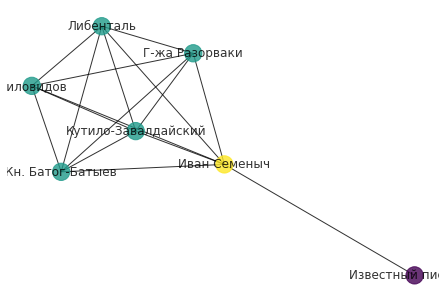

In [457]:
my_pos = nx.circular_layout(play_graph_dict["prutkov-oprometchivyj-turka"]) 
plt.figure() 

val_map = {"Lead": 1, "Secondary": 0.54, "Episode": 0} 
values = [val_map.get(play_graph_dict["prutkov-oprometchivyj-turka"].nodes()[node]["importance"], 0.25) 
          for node in play_graph_dict["prutkov-oprometchivyj-turka"].nodes()]

nx.draw_spring(play_graph_dict["prutkov-oprometchivyj-turka"], 
               node_color=values,#"mediumvioletred",  
               alpha=0.8, 
               with_labels=True,
               labels = labels)

### Lets's make our dataset 
We collect all the possible features in one dataframe

In [458]:
gender_dict = {'FEMALE': 0, 'MALE':1, 'UNKNOWN':3}
importance_dict = {'Lead':0, 'Secondary':1, 'Episode':2}
for_df = []
for play in dict_with_lead_markup:
    play_dict = dict_with_lead_markup[play]
    for node in play_dict.nodes():
        name = play_dict.nodes()[node]['label']
        degr = round(nx.degree_centrality(play_dict)[node], 3)
        betw = round(nx.betweenness_centrality(play_dict)[node], 3)
        pagerank = round(nx.pagerank(play_dict)[node], 3)
        num_of_words = round(play_dict.nodes()[node]['relative_num_of_words'], 5)
        gender = gender_dict[play_dict.nodes()[node]['Gender']]
        try:
            imp = importance_dict[play_dict.nodes()[node]['importance']]
        except:
            continue
        data = [play, name, degr, betw, pagerank, num_of_words, gender, imp]
        for_df.append(data)
    

In [459]:
import pandas as pd
#
df = pd.DataFrame(for_df, columns=['play', 'name', 'degree_cent', 'between_cent', 'pagerank', 'relative_words', 'gender', 'importance'])

In [460]:
df.loc[df['importance']==0] # 123 main roles

,play,name,degree_cent,between_cent,pagerank,relative_words,gender,importance
0,fonvizin-brigadir,Советник,1.00,0.008,0.136,0.19902,1,0
1,fonvizin-brigadir,Сын,1.00,0.008,0.161,0.18411,1,0
2,fonvizin-brigadir,Бригадир,1.00,0.008,0.141,0.20819,1,0
3,fonvizin-brigadir,Советница,1.00,0.008,0.175,0.15308,0,0
4,fonvizin-brigadir,Бригадирша,1.00,0.008,0.125,0.16122,0,0
...,...,...,...,...,...,...,...,...
327,chekhov-medved,Смирнов,1.00,0.000,0.310,0.56205,1,0
328,chekhov-jubilej,Хирин,0.75,0.000,0.192,0.22449,1,0
329,chekhov-jubilej,Шипучин,1.00,0.056,0.273,0.34763,1,0
330,chekhov-jubilej,Татьяна Алексеевна,1.00,0.056,0.216,0.20858,0,0


In [462]:
df.loc[df['importance']==1] # 135 supporting roles

,play,name,degree_cent,between_cent,pagerank,relative_words,gender,importance
5,fonvizin-brigadir,Софья,1.000,0.008,0.117,0.05288,0,1
7,fonvizin-brigadir,Добролюбов,0.857,0.000,0.110,0.04114,1,1
8,mamin-sibirjak-zolotopromyshlenniki,Белоносов,0.800,0.007,0.140,0.11100,1,1
9,mamin-sibirjak-zolotopromyshlenniki,Ширинкин,0.800,0.013,0.095,0.10451,1,1
11,mamin-sibirjak-zolotopromyshlenniki,Воротов,0.800,0.013,0.107,0.08289,1,1
...,...,...,...,...,...,...,...,...
314,sumarokov-vzdorschitsa,Ераст,0.857,0.000,0.139,0.03812,1,1
316,sumarokov-vzdorschitsa,Ворожея,0.857,0.000,0.068,0.05566,0,1
317,majkov-agriopa,Альбина,0.857,0.024,0.134,0.05445,0,1
321,majkov-agriopa,Аристон,0.857,0.024,0.100,0.06821,1,1


In [464]:
df.loc[df['importance']==2] # 75 episode roles

,play,name,degree_cent,between_cent,pagerank,relative_words,gender,importance
6,fonvizin-brigadir,Слуга,0.857,0.000,0.035,0.00034,1,2
15,mamin-sibirjak-zolotopromyshlenniki,Мосевна,0.900,0.028,0.052,0.04898,0,2
17,mamin-sibirjak-zolotopromyshlenniki,Даша,0.200,0.000,0.022,0.00315,0,2
18,mamin-sibirjak-zolotopromyshlenniki,Чепраков,0.600,0.000,0.064,0.01488,1,2
20,turgenev-zavtrak-u-predvoditelja,Герасим,0.800,0.013,0.085,0.01014,1,2
...,...,...,...,...,...,...,...,...
309,turgenev-vecher-v-sorrente,Голос певца,0.333,0.000,0.057,0.00507,1,2
320,majkov-agriopa,Военачальник,0.714,0.000,0.117,0.03547,1,2
323,majkov-agriopa,Один воин,0.143,0.000,0.027,0.00136,1,2
324,majkov-agriopa,Вестник,0.714,0.000,0.060,0.03012,1,2


In [ ]:
df.sample(frac=1) # shuffle our df

In [231]:
# we take just degree_cent, pagerank, relative_words as features for prediction because statistical test showed that
# between_cent is not statistically significant

In [465]:
X = df.filter(['degree_cent', 'pagerank', 'relative_words']).values.tolist() # features
Y = df['importance'].values.tolist() # classes

In [466]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42) 

In [468]:
clf = svm.SVC(decision_function_shape='ovo') # one vs one classifier
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [469]:
y_pred=clf.predict(X_test)

In [470]:
accuracy_score(y_test, y_pred)

0.7058823529411765

In [471]:
f1_score(y_test, y_pred, average='macro')

0.6900584795321637

In [472]:
f1_score(y_test, y_pred, average='micro')

0.7058823529411765